# CEO-Request Challenge

## 1. Summary of Problem Statement

❓ **How could Olist improve its profit** ❓

### P&L Rules

#### Revenues  
**Sales fees:** Olist takes a **10% cut** on the product price (excl. freight) of each order delivered  
**Subscription fees:** Olist charges **80 BRL by month** per seller

#### Costs
_Estimated_ **reputation costs** of orders with bad reviews (<= 3 stars)  

💡 In the long term, bad customer experience has business implications: low repeat rate, immediate customer support cost, refunds or unfavorable word of mouth communication. We make an assumption about the monetary cost for each bad review:

```python
# review_score: cost(BRL)
{'1 star': 100
'2 stars': 50
'3 stars': 40
'4 stars': 0
'5 stars': 0}
```

**IT costs:** Olist's **total cumulated IT Costs** scale with the square root of the total number of sellers that have ever joined the platform, as well as with the square root of the total cumulated number of items that were ever sold.  

$IT\_costs = \alpha * \sqrt{n\_sellers} + \beta * \sqrt{n\_items}$  

Olist's data team gave us the following values for these scaling parameters:
- $\alpha = 3157.27$
- $\beta = 978.23$

💡 Both the number of sellers to manage and the number of sales transaction are costly for IT systems.  
💡 Yet square roots reflect scale-effects: IT-system are often more efficient as they grow bigger.  
💡 Alpha > Beta means that Olist has a lower IT Cost with few sellers selling a lot of items rather than the opposite  
- with **1000 sellers** and a total of **100 items** sold, the total IT cost accumulates to 109,624 BRL
- with **100 sellers** and a total of **1000 items** sold, the total IT cost accumulates to 62,507 BRL

Finally, The IT department also told you that since the birth of the marketplace, cumulated IT costs have amounted to **500,000 BRL**.

Let's understand that IT cost formula a bit better, by running a simulation. No need to spend time on the code, just look at the resulting charts.

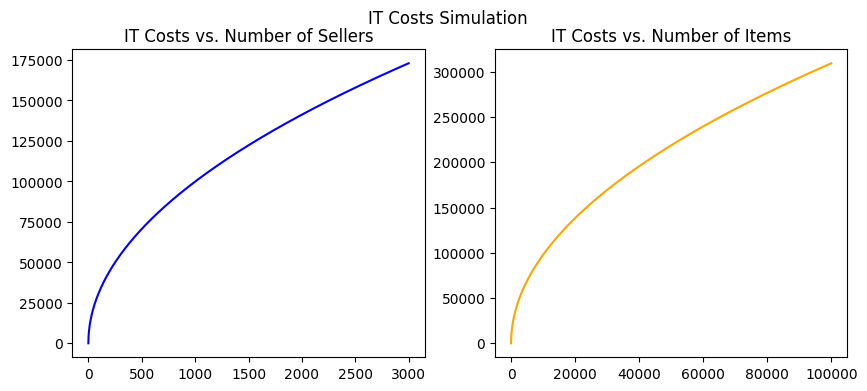

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

alpha = 3157.27
beta = 978.23

x_sellers = np.arange(3_000)
y_it_costs_sellers = alpha * x_sellers ** 0.5

x_items = np.arange(100_000)
y_it_costs_items = beta * x_items ** 0.5

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(x_sellers, y_it_costs_sellers, label='IT costs per seller', color='blue')
plt.title('IT Costs vs. Number of Sellers')
plt.subplot(1, 2, 2)
plt.plot(x_items, y_it_costs_items, label='IT costs per item', color='orange')
plt.title('IT Costs vs. Number of Items')
plt.suptitle('IT Costs Simulation');

### Key Findings, so far

- `wait_time` is the most significant factor behind low review scores.  
- `wait_time` is made up of seller's `delay_to_carrier` + `carrier_delivery_time`. 
- Because the carrier's delivery time is out of Olist's direct control, improving it is not a quick-win recommendation.
- On the contrary, a better selection of `sellers` can positively impact the `delay_to_carrier` and reduce the number of bad `review_scores` on Olist.
- Comments in the bad reviews showed that some were linked to the seller or to the product itself.

💡 We recommend you to start with the the guided seller analysis in part 2 below.

💪 But feel free to investigate into other hypothesis instead with part 3.


import pandas as pd
import numpy as np
from olist.data import Olist
from olist.order import Order


class Seller:
    def __init__(self):
        # Import data only once
        olist = Olist()
        self.data = olist.get_data()
        self.order = Order()

    def get_seller_features(self):
        """
        Returns a DataFrame with:
        'seller_id', 'seller_city', 'seller_state'
        """
        sellers = self.data['sellers'].copy(
        )  # Make a copy before using inplace=True so as to avoid modifying self.data
        sellers.drop('seller_zip_code_prefix', axis=1, inplace=True)
        sellers.drop_duplicates(
            inplace=True)  # There can be multiple rows per seller
        return sellers

    def get_seller_delay_wait_time(self):
        """
        Returns a DataFrame with:
        'seller_id', 'delay_to_carrier', 'wait_time'
        """
        # Get data
        order_items = self.data['order_items'].copy()
        orders = self.data['orders'].query("order_status=='delivered'").copy()

        ship = order_items.merge(orders, on='order_id')

        # Handle datetime
        ship.loc[:, 'shipping_limit_date'] = pd.to_datetime(
            ship['shipping_limit_date'])
        ship.loc[:, 'order_delivered_carrier_date'] = pd.to_datetime(
            ship['order_delivered_carrier_date'])
        ship.loc[:, 'order_delivered_customer_date'] = pd.to_datetime(
            ship['order_delivered_customer_date'])
        ship.loc[:, 'order_purchase_timestamp'] = pd.to_datetime(
            ship['order_purchase_timestamp'])

        # Compute delay and wait_time
        def delay_to_logistic_partner(d):
            days = np.mean(
                (d.order_delivered_carrier_date - d.shipping_limit_date) /
                np.timedelta64(24, 'h'))
            if days > 0:
                return days
            else:
                return 0

        def order_wait_time(d):
            days = np.mean(
                (d.order_delivered_customer_date - d.order_purchase_timestamp)
                / np.timedelta64(24, 'h'))
            return days

        delay = ship.groupby('seller_id')\
                    .apply(delay_to_logistic_partner)\
                    .reset_index()
        delay.columns = ['seller_id', 'delay_to_carrier']

        wait = ship.groupby('seller_id')\
                   .apply(order_wait_time)\
                   .reset_index()
        wait.columns = ['seller_id', 'wait_time']

        df = delay.merge(wait, on='seller_id')

        return df

    def get_active_dates(self):
        """
        Returns a DataFrame with:
        'seller_id', 'date_first_sale', 'date_last_sale', 'months_on_olist'
        """
        # First, get only orders that are approved
        orders_approved = self.data['orders'][[
            'order_id', 'order_approved_at'
        ]].dropna()

        # Then, create a (orders <> sellers) join table because a seller can appear multiple times in the same order
        orders_sellers = orders_approved.merge(self.data['order_items'],
                                               on='order_id')[[
                                                   'order_id', 'seller_id',
                                                   'order_approved_at'
                                               ]].drop_duplicates()
        orders_sellers["order_approved_at"] = pd.to_datetime(
            orders_sellers["order_approved_at"])

        # Compute dates
        orders_sellers["date_first_sale"] = orders_sellers["order_approved_at"]
        orders_sellers["date_last_sale"] = orders_sellers["order_approved_at"]
        df = orders_sellers.groupby('seller_id').agg({
            "date_first_sale": "min",
            "date_last_sale": "max"
        })
        df['months_on_olist'] = round(
            (df['date_last_sale'] - df['date_first_sale']) /
            np.timedelta64(30, 'D'))
        return df

    def get_quantity(self):
        """
        Returns a DataFrame with:
        'seller_id', 'n_orders', 'quantity', 'quantity_per_order'
        """
        order_items = self.data['order_items']

        n_orders = order_items.groupby('seller_id')['order_id']\
            .nunique()\
            .reset_index()
        n_orders.columns = ['seller_id', 'n_orders']

        quantity = order_items.groupby('seller_id', as_index=False).agg(
            {'order_id': 'count'})
        quantity.columns = ['seller_id', 'quantity']

        result = n_orders.merge(quantity, on='seller_id')
        result['quantity_per_order'] = result['quantity'] / result['n_orders']
        return result

    def get_sales(self):
        """
        Returns a DataFrame with:
        'seller_id', 'sales'
        """
        return self.data['order_items'][['seller_id', 'price']]\
            .groupby('seller_id')\
            .sum()\
            .rename(columns={'price': 'sales'})

    def get_review_score(self):
        """
        Returns a DataFrame with:
        'seller_id', 'share_of_five_stars', 'share_of_one_stars', 'review_score'
        """

        pass  # YOUR CODE HERE

    def get_training_data(self):
        """
        Returns a DataFrame with:
        ['seller_id', 'seller_city', 'seller_state', 'delay_to_carrier',
        'wait_time', 'date_first_sale', 'date_last_sale', 'months_on_olist', 'share_of_one_stars',
        'share_of_five_stars', 'review_score', 'n_orders', 'quantity',
        'quantity_per_order', 'sales']
        """

        training_set =\
            self.get_seller_features()\
                .merge(
                self.get_seller_delay_wait_time(), on='seller_id'
               ).merge(
                self.get_active_dates(), on='seller_id'
               ).merge(
                self.get_quantity(), on='seller_id'
               ).merge(
                self.get_sales(), on='seller_id'
               )

        if self.get_review_score() is not None:
            training_set = training_set.merge(self.get_review_score(),
                                              on='seller_id')

        return training_set


## 2. Should Olist remove under-performing sellers from its marketplace? 🕵🏻
*(recommended)*

To analyze the impact of removing the worst sellers from Olist's marketplace, we will perform a **what-if analysis**

👉 **What would have happened if Olist had never accepted these sellers in the first place?**  

*(In practice, it's hard to know in advance who is a good seller, but let's start with this approach and iterate later).*

### 2.1 Data Preparation

Compute, for each `seller_id`, and cumulated since the beginning:
- the `revenues` the seller brings
- the `review_costs` associated with the seller's bad reviews
- the resulting `profits` (revenues - costs)

👉 Write down a step-by-step strategy to create the DataFrame you need.

⚠️ **Don't start from scratch, update your existing package!** 😉

**The solution to this lies in changing the code in your `.py` files, not in writing new code in your notebook.**

Starting from the `Seller` class of your `olist` package:

Edit the `get_training_data` method so that the DataFrame it returns contains the fields:
- `revenues`: sum of subscription and sales fees revenues
- `cost_of_reviews`: sum of costs associated with bad reviews
- `profits`: `revenues` - `cost_of_reviews`

For `cost_of_reviews` you'll need to change another method first. Which one is related to this?

In [ ]:
from olist.seller import Seller

# création instance
seller = Seller()
sellers = seller.get_training_data()
sellers.head()


,seller_id,seller_city,seller_state,delay_to_carrier,wait_time,date_first_sale,date_last_sale,months_on_olist,n_orders,quantity,quantity_per_order,sales
0,3442f8959a84dea7ee197c632cb2df15,campinas,SP,0.000000,13.018588,2017-05-05 16:25:11,2017-08-30 12:50:19,4.0,3,3,1.000,218.70
1,d1b65fc7debc3361ea86b5f14c68d2e2,mogi guacu,SP,0.000000,9.065716,2017-03-29 02:10:34,2018-06-06 20:15:21,14.0,40,41,1.025,11703.07
2,ce3ad9de960102d0677a81f5d0bb7b2d,rio de janeiro,RJ,0.000000,4.042292,2018-07-30 12:44:49,2018-07-30 12:44:49,0.0,1,1,1.000,158.00
3,c0f3eea2e14555b6faeea3dd58c1b1c3,sao paulo,SP,0.000000,5.667187,2018-08-03 00:44:08,2018-08-03 00:44:08,0.0,1,1,1.000,79.99
4,51a04a8a6bdcb23deccc82b0b80742cf,braganca paulista,SP,3.353727,35.314861,2017-11-14 12:15:25,2017-11-14 12:15:25,0.0,1,1,1.000,167.99


### 2.2 What-if Analysis without IT costs

👉 Time to perform the actual analysis. First we'll do it **without** taking into account the IT costs.

Here are our steps:  

1️⃣ Load the sellers data and sort them by decreasing profits.

2️⃣ Calculate cumulative amounts:
   - Calculate the cumulative revenues for each row.
   - Calculate the cumulative profits for each row.
   - Calculate the cumulative quantity of items sold for each row.

   Look up how you can calculate cumulative sums with Pandas.

3️⃣ Plot your results, and analyze them. Use Pandas' `.plot()` method.

4️⃣ Determine the optimum number of sellers to keep, based on profits. (Hint: look up `np.argmax`). What would have been the impact on:
   - Net profit (before IT costs because we didn't include those yet)?
   - Total revenues?
   - Number of sellers?
   - Number of items sold?

In [ ]:
# YOUR CODE HERE

### 2.3 What-if Analysis with IT costs (Optional)

👉 Time to perform the actual analysis, this time including IT costs.

Here are our steps:  

1️⃣ Write a function that will calculate IT costs based on two parameters: number of sellers and number of items. Basically write out the mathematical formula using python.

2️⃣ Load the sellers data and sort them by decreasing profits (before IT costs).

3️⃣ Calculate cumulative amounts (reuse the code from before):
   - Calculate the cumulative revenues for each row.
   - Calculate the cumulative profits for each row.
   - Calculate the cumulative quantity of items sold for each row.  

4️⃣ Calculate the impact of IT costs:
   - Using the function you wrote in step 1️⃣, add the cumulative cost of IT for each row.
   - Calculate net profit after IT costs.

5️⃣ Plot your results, and analyze them.

6️⃣ Determine the optimum number of sellers to keep, based on profits after IT costs this time. What would have been the impact on:
   - Net profit after IT costs?
   - Net profit before IT costs
   - IT costs?
   - Total revenues?
   - Number of sellers?
   - Number of items sold?

How important were the IT costs in your analysis?

In [ ]:
# YOUR CODE HERE

## 3. Investigate other Approaches 🕵️
*(optional)*

- Should Olist remove the worst performing products / categories from its marketplace entirely?
- Should Olist remove only consistently underperforming sellers, after a honeymoon period of a few months?
- Should Olist enforce sellers to include certain information on their product listings?
- Should Olist ask customers for purchase confirmation at certain times of day?
- Should Olist restrict seller/customer pairs between certain states to avoid delays?
- Should Olist acquire new sellers, with some cost assumptions to be suggested?
- ...


## Your turn!

🧺 Keep this notebook tidy! 

🗣 📊 You will present your insights to your favorite TA at the end of this `Communicate` unit 💪